# MNIST error surface
 
 > To run this notebook it's necessary to have TF2.2 modules loaded. Please use the kernel miniconda-sc2020:

```bash
. /apps/daint/UES/6.0.UP04/sandboxes/sarafael/miniconda-ss2020/bin/activate
module load daint-gpu                             
module load jupyter-utils
kernel-create -n miniconda-sc2020
```
 
Please, make sure that it doesn't conflict with any other line that you might have on your `$HOME/.jupyterhub.env` file.

In [2]:
import os
import json
import numpy as np

import tensorflow as tf
import tensorflow_addons as tfa

tf.__version__

'2.2.0'

In [3]:
import random

seed = 42
random.seed(seed)
np.random.seed(seed)
tf.random.set_seed(seed)
os.environ['PYTHONHASHSEED'] = str(seed)
os.environ['TF_DETERMINISTIC_OPS'] = '1'

In [4]:
strategy = tf.distribute.get_strategy() # default strategy

tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [5]:
batch_size = 100
learning_rate = 5e-4 * batch_size

learning_rate

0.05

In [6]:
def build_and_compile_cnn_model(learning_rate=learning_rate):
    model = tf.keras.Sequential([
        tf.keras.Input(shape=(28, 28)),
        tf.keras.layers.Reshape(target_shape=(28, 28, 1)),
        tf.keras.layers.Conv2D(32, 3, activation='relu'),
        tf.keras.layers.experimental.SyncBatchNormalization(name='bn0'),
        tf.keras.layers.Conv2D(64, 3, activation='relu'),
        tf.keras.layers.experimental.SyncBatchNormalization(name='bn1'),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.experimental.SyncBatchNormalization(name='bn2'),
        tf.keras.layers.Dense(10)
    ])
    model.compile(
#         loss=tf.keras.losses.SparseCategoricalCrossentropy(
#             from_logits=True),
        loss=tf.keras.losses.CategoricalCrossentropy(
            from_logits=True, label_smoothing=0.01),
        optimizer=tfa.optimizers.SGDW(
            learning_rate=learning_rate, momentum=0.9, nesterov=True,
            weight_decay=1e-4),
        metrics=['accuracy'])
    model.summary()
    return model


with strategy.scope():
    # Model building/compiling need to be within `strategy.scope()`.
    model = build_and_compile_cnn_model()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape (Reshape)            (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d (Conv2D)              (None, 26, 26, 32)        320       
_________________________________________________________________
bn0 (SyncBatchNormalization) (None, 26, 26, 32)        128       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 24, 24, 64)        18496     
_________________________________________________________________
bn1 (SyncBatchNormalization) (None, 24, 24, 64)        256       
_________________________________________________________________
flatten (Flatten)            (None, 36864)             0         
_________________________________________________________________
dense (Dense)                (None, 128)               4

In [7]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

train_size = len(y_train)
valid_size = len(y_test)

# The `x` arrays are in uint8 and have values in the range [0, 255].
# We need to convert them to float32 with values in the range [0, 1]
train_dataset = (tf.data.Dataset
                        .from_tensor_slices((x_train / np.float32(255), 
#                                              y_train.astype(np.int64)
                                             tf.keras.backend.one_hot(
                                                 y_train, 10)
                                           ))
                        .shuffle(train_size)
                        .repeat()
                        .batch(batch_size, drop_remainder=True))

valid_dataset = (tf.data.Dataset
                        .from_tensor_slices((x_test / np.float32(255),
#                                              y_test.astype(np.int64)
                                             tf.keras.backend.one_hot(
                                                 y_test, 10)
                                           ))
                        .batch(batch_size, drop_remainder=False))

# In multi-worker training with MultiWorkerMirroredStrategy, sharding the dataset
# is needed to ensure convergence and performance. However, note that in code here,
# the datasets are directly passed to model.fit() without needing to shard; this is
# because tf.distribute.Strategy API takes care of the dataset sharding automatically.

train_size, valid_size

(60000, 10000)

In [8]:
from datetime import datetime

output_path = f"{os.environ['SCRATCH']}/keras-mnist"
if not os.path.exists(output_path):
    os.makedirs(output_path)

run_path = f"{output_path}/r{datetime.now().strftime('%Y%m%d-%H%M%S')}"

tb_logdir = f'{run_path}/logs'
tensorboard_cb = tf.keras.callbacks.TensorBoard(log_dir=tb_logdir, histogram_freq=1)

tb_logdir

'/scratch/snx3000/dealmeih/keras-mnist/r20200713-085608/logs'

In [9]:
steps_per_epoch = train_size//batch_size
validation_steps = np.ceil(valid_size/batch_size).astype(int)
print(f'Training for {steps_per_epoch} steps per epoch')

Training for 600 steps per epoch


In [10]:
weights_path = output_path + '/weights.h5'
try:
    model.load_weights(weights_path)
except:
    model.fit(train_dataset,
              epochs=1,
              steps_per_epoch=steps_per_epoch,
              validation_data=valid_dataset,
              validation_steps=validation_steps,
             )
    model.save_weights(weights_path)

In [11]:
%%time
model.evaluate(valid_dataset, batch_size=batch_size, steps=validation_steps)

100/100 [==============================] - 0s 3ms/step - loss: 0.1054 - accuracy: 0.9913
CPU times: user 1.55 s, sys: 945 ms, total: 2.5 s
Wall time: 6.33 s


[0.10535039007663727, 0.9912999868392944]

In [12]:
epoch_fraction = 100

checkpoint_path = run_path + '/weights{epoch:03d}-loss{loss:.06f}-acc{accuracy:.06f}-val{val_loss:.06f}-vacc{val_accuracy:.06f}.h5'
checkpoint_cb = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_path,
    save_weights_only=True)
callbacks = [tensorboard_cb, checkpoint_cb]
print('checkpoint_path:', checkpoint_path)

model.fit(train_dataset,
          epochs=1 * epoch_fraction,
          steps_per_epoch=steps_per_epoch//epoch_fraction,
          validation_data=valid_dataset,
          validation_steps=validation_steps,
          callbacks=callbacks,
         )

checkpoint_path: /scratch/snx3000/dealmeih/keras-mnist/r20200713-085608/weights{epoch:03d}-loss{loss:.06f}-acc{accuracy:.06f}-val{val_loss:.06f}-vacc{val_accuracy:.06f}.h5
Epoch 1/100
6/6 [==============================] - 1s 144ms/step - loss: 0.0799 - accuracy: 1.0000 - val_loss: 0.1030 - val_accuracy: 0.9914
Epoch 2/100
6/6 [==============================] - 1s 125ms/step - loss: 0.0796 - accuracy: 1.0000 - val_loss: 0.1037 - val_accuracy: 0.9918
Epoch 3/100
6/6 [==============================] - 1s 118ms/step - loss: 0.0795 - accuracy: 1.0000 - val_loss: 0.1044 - val_accuracy: 0.9923
Epoch 4/100
6/6 [==============================] - 1s 123ms/step - loss: 0.0795 - accuracy: 1.0000 - val_loss: 0.1042 - val_accuracy: 0.9922
Epoch 5/100
6/6 [==============================] - 1s 121ms/step - loss: 0.0787 - accuracy: 1.0000 - val_loss: 0.1030 - val_accuracy: 0.9923
Epoch 6/100
6/6 [==============================] - 1s 125ms/step - loss: 0.0786 - accuracy: 1.0000 - val_loss: 0.1022 - val

### Plotting the SGD

Plot the path taken by the SGD during training. This shows the path taken by both workers. They must be identical, if they aren't, it means that something on the distributed SGD algorithm went wrong.

>To plot the path individually, the options `--target 0` and `--target 1` of `%%px` can be used.

In [13]:
%%time
from glob import glob
import numpy as np

# files = sorted(glob(output_path + '/*/*.h5'))
files = sorted(glob(run_path + '/*.h5'))
# files = files[-len(files)//4:]
weights = []
for f in files:
    model.load_weights(f)
    weights.append(np.concatenate([w.numpy().ravel() for w in model.weights]))
    
weights = np.stack(weights)
print(weights.shape)

(100, 4739722)
CPU times: user 3.12 s, sys: 1.54 s, total: 4.65 s
Wall time: 4.5 s


In [14]:
%%time
from sklearn.decomposition import PCA
pca = PCA(n_components=2, whiten=True)
d2  = pca.fit_transform(weights)
# pca.fit(weights[-len(weights)//4:])
# d2 = pca.transform(weights)
print(d2.shape, 'cumulative explained variance:', pca.explained_variance_ratio_.cumsum())

(100, 2) cumulative explained variance: [0.9488003 0.9710031]
CPU times: user 58.1 s, sys: 27.1 s, total: 1min 25s
Wall time: 16.1 s


In [15]:
import pandas as pd
pd.DataFrame(d2, columns=['pca1', 'pca2']).describe()

,pca1,pca2
count,1.000000e+02,100.000000
mean,3.218651e-08,-0.000001
std,1.000000e+00,1.000000
min,-1.447797e+00,-1.416029
25%,-9.030979e-01,-0.989989
50%,-7.520891e-02,0.003597
75%,8.660135e-01,1.043406
max,1.776551e+00,1.592489


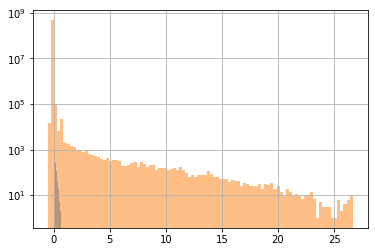

In [16]:
w_hat = pca.inverse_transform(d2)
l1er = abs(weights - w_hat).flatten()
# pd.Series(l1er).describe()
pd.Series(l1er).hist(bins=100, log=True, alpha=0.6)
pd.Series(weights.flatten()).hist(bins=100, log=True, alpha=0.5)

In [17]:
%matplotlib inline
from tqdm import tqdm
import matplotlib
import matplotlib.pyplot as plt
comp1 = d2[:, 0]
comp2 = d2[:, 1]

# Create [slope x offset] grid for contour plot
margin = 1.25
_m = np.linspace(comp1.min()*margin, comp1.max()*margin, num=30)
_n = np.linspace(comp2.min()*margin, comp2.max()*margin, num=30)
M, N = np.meshgrid(_m, _n)
print(len(_m), len(_n), len(_m) * len(_n))

30 30 900


In [ ]:
plot_batch_size = 1000

# calc error surface
def loss_func(u, v):
    print(u, v)
    flat_w = pca.inverse_transform([u, v])

#     # smooth extrapolated weights by using an exponential average of all weights
#     std = np.std(weights, axis=0)
#     l2dist = (((weights - flat_w) / (std+1e-6))**2).mean(axis=1)
#     top = np.argsort(l2dist)
#     avgw = np.expm1(1/l2dist)
#     flat_w = np.average(np.concatenate([[flat_w], weights]), axis=0,
#                         weights=[len(avgw)]+list(avgw))

    sizes = np.array([np.prod(w.shape) for w in model.weights])
    idx = [0] + sizes.cumsum().tolist()
    for i, s, w in zip(idx, sizes, model.weights):
        w.assign(flat_w[i:i+s].reshape(w.shape))
    bloss, acc = model.evaluate(train_dataset, batch_size=plot_batch_size, steps=10)
    val_loss, val_acc = model.evaluate(valid_dataset, batch_size=500, steps=validation_steps)
    return bloss, acc, val_loss, val_acc

loss = np.zeros(M.shape)
loss = np.stack([loss]*4, -1)
for i in tqdm(range(M.shape[0])):
    for j in range(N.shape[1]):
        (loss[i, j, 0],
         loss[i, j, 1],
         loss[i, j, 2],
         loss[i, j, 3]) = loss_func(M[i, j], N[i, j])

np.save(output_path + f'/loss{plot_batch_size}.npy', loss)

In [38]:
from matplotlib.collections import LineCollection
cmap = 'viridis'

def plot(Z, values):
    fig, axs = plt.subplots(1, sharex=False, sharey=True, figsize=(10, 10))

    if Z.max() > 0:
        cp = plt.contour(M, N, Z, 50, vmin=values.min(), vmax=values.max(), alpha=0.6, cmap=cmap)
        plt.clabel(cp, cp.levels[:6])
        plt.colorbar()

    ## Plot optimization paths
    for folder in np.unique([f[:56] for f in files]):
        c1 = comp1[[(folder in f) for f in files]]
        c2 = comp2[[(folder in f) for f in files]]
        # plt.plot(c1, c2, '.-', lw=2)
        points = np.array([c1, c2]).T.reshape(-1, 1, 2)
        segments = np.concatenate([points[:-1], points[1:]], axis=1)
        # Create a continuous norm to map from data points to colors
        norm = plt.Normalize(values.min(), values.max())
        lc = LineCollection(segments, cmap=cmap, norm=norm)
        # Set the values used for colormapping
        lc.set_array(values)
        lc.set_linewidth(2)
        line = axs.add_collection(lc)

    m = comp1[-1]
    n = comp2[-1]
    plt.xlim([_m.min(), _m.max()])
    plt.ylim([_n.min(), _n.max()])
    plt.xlabel('PCA1')
    plt.ylabel('PCA2')

    plt.show()

# Z = loss[..., 0] # batch loss
# Z = np.nan_to_num(Z, nan=12)
# values = np.array([float(f[70:78]) for f in files])
# plot(Z, values)

# Z = loss[..., -1] # val accuracy
# if Z.max() > 0:  Z[Z < 0.98] = 0.98
# values = np.array([float(f[107:115]) for f in files])
# plot(Z, values)

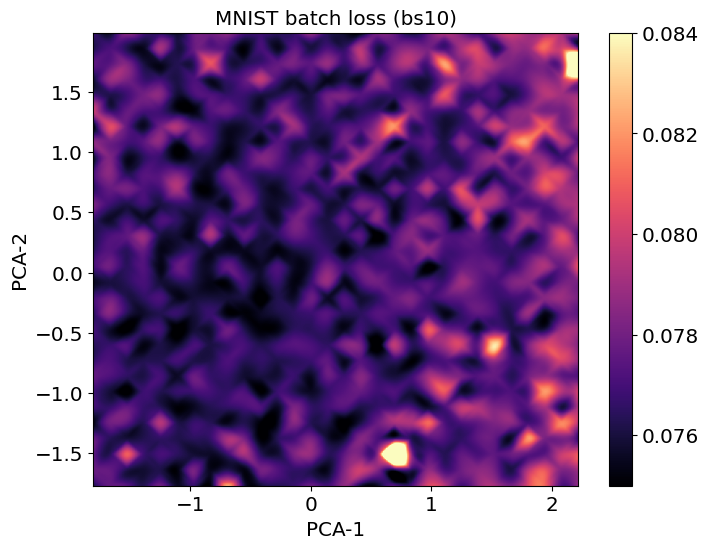

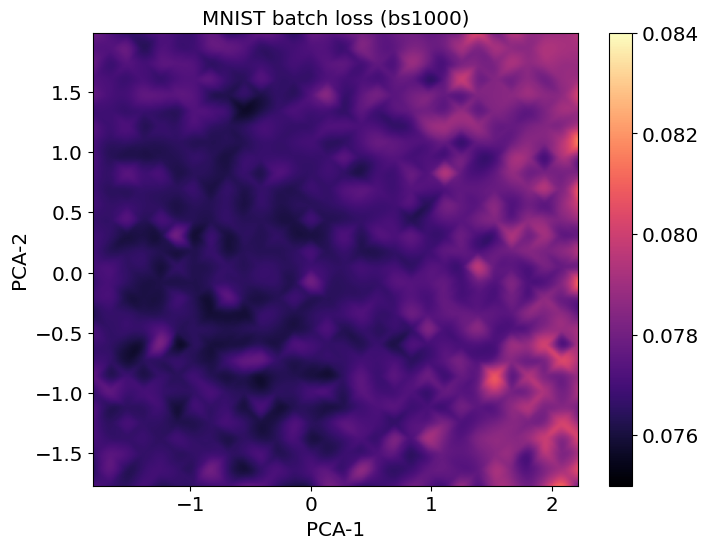

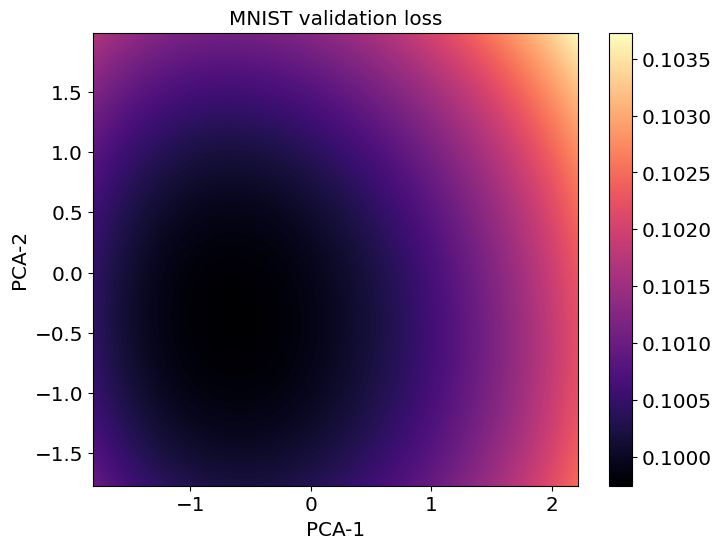

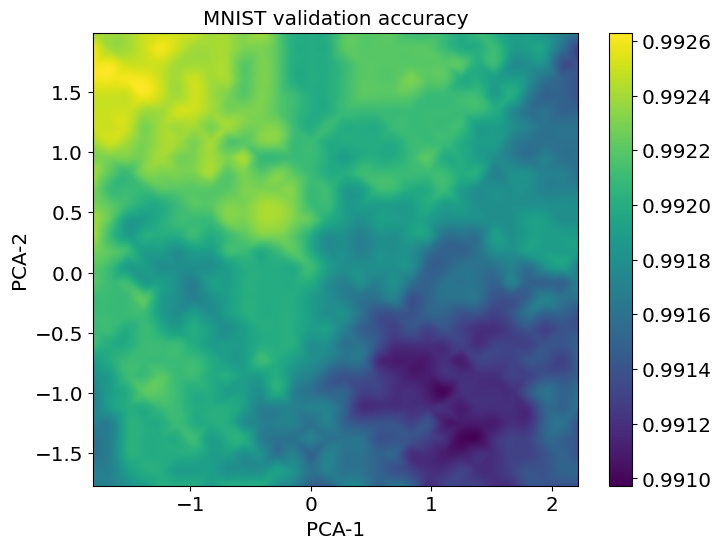

In [57]:
from scipy.interpolate import griddata

def plot_surface(Z, values=None, title=None, cmap='viridis', method='cubic', vmin=None, vmax=None):
    import matplotlib.pylab as pylab
    params = {'legend.fontsize': 'x-large',
              'figure.figsize': (15, 5),
             'axes.labelsize': 'x-large',
             'axes.titlesize':'x-large',
             'xtick.labelsize':'x-large',
             'ytick.labelsize':'x-large',
             'figure.dpi': 100}
    pylab.rcParams.update(params)
    fig, axs = plt.subplots(1, sharex=False, sharey=True, figsize=(8, 6))
    
    # points = np.concatenate([np.array([M, N]).reshape(2, -1).T, d2])
    # f_values = np.concatenate([Z.flatten(), values])
    points = np.array([M, N]).reshape(2, -1).T
    f_values = Z.flatten()
    # plt.imshow(grid_c.T, extent=(0,1,0,1), origin='lower')
#     print(Z.max(), values.max())

    # Create [slope x offset] grid for contour plot
    f_m = np.linspace(points[:,0].min(), points[:,0].max(), num=300)
    f_n = np.linspace(points[:,1].min(), points[:,1].max(), num=300)
    fM, fN = np.meshgrid(f_m, f_n)

    grid_n = griddata(points, f_values, (fM, fN), method='nearest')
    grid_c = griddata(points, f_values, (fM, fN), method=method)
    grid_c[np.isnan(grid_c)] = grid_n[np.isnan(grid_c)]
    plt.imshow(grid_c, extent=(f_m.min(), f_m.max(), f_n.min(), f_n.max()), origin='lower', cmap=cmap, vmin=vmin, vmax=vmax)
    # cp = plt.contour(fM, fN, grid_c, 50, vmin=f_values.min(), vmax=f_values.max(), alpha=0.6, cmap=cmap)
    plt.colorbar()

    m = comp1[-1]
    n = comp2[-1]
    plt.xlim([_m.min(), _m.max()])
    plt.ylim([_n.min(), _n.max()])
    plt.xlabel('PCA-1')
    plt.ylabel('PCA-2')
    plt.title(title)
    plt.show()



loss_limit = dict(vmin=0.075, vmax=0.084)

loss = np.load(output_path + f'/loss10.npy')

Z = loss[..., 0] # batch loss
Z = np.nan_to_num(Z, nan=12)
# values = np.array([float(f[70:78]) for f in files])
plot_surface(Z, title='MNIST batch loss (bs10)', cmap='magma', method='cubic', **loss_limit)

loss = np.load(output_path + f'/loss1000.npy')

Z = loss[..., 0] # batch loss
Z = np.nan_to_num(Z, nan=12)
# values = np.array([float(f[70:78]) for f in files])
plot_surface(Z, title='MNIST batch loss (bs1000)', cmap='magma', method='cubic', **loss_limit)

loss = np.load(output_path + f'/loss300.npy')

Z = loss[..., 2] # val loss
Z = np.nan_to_num(Z, nan=12)
# values = np.array([float(f[94:102]) for f in files])
plot_surface(Z, title='MNIST validation loss', cmap='magma')

Z = loss[..., 3] # val accuracy
if Z.max() > 0:  Z[Z < 0.98] = 0.98
# values = np.array([float(f[107:115]) for f in files])
plot_surface(Z, title='MNIST validation accuracy')

#### 